# Imports

In [1]:
%load_ext autoreload
%autoreload 2
# from src.vnc import run_vnc_simulation


import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
from pathlib import Path
from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
import jax
# jax.config.update("jax_enable_x64", True)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Use GPU 0
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
import sparse

from src.optimized_vnc2 import *
from src.plot_utils import *


In [2]:
experiment='Stim_Neurons'
with initialize(version_base=None, config_path="../configs"):
    cfg=compose(config_name='config.yaml', overrides= [f"experiment={experiment}", "paths=glados", "version=debug", f'run_id=Testing'],return_hydra_config=True,)
    HydraConfig.instance().set_config(cfg)

for k in cfg.paths.keys():
    if (k != 'user'):
        cfg.paths[k] = Path(cfg.paths[k])
        cfg.paths[k].mkdir(parents=True, exist_ok=True)




# experiment='default'
# with initialize(version_base=None, config_path="../configs"):
#     cfg_old=compose(config_name='config.yaml', overrides= [f"experiment={experiment}", "paths=glados", "version=debug", f'run_id=Testing'],return_hydra_config=True,)
#     HydraConfig.instance().set_config(cfg_old)

# for k in cfg_old.paths.keys():
#     if (k != 'user'):
#         cfg_old.paths[k] = Path(cfg_old.paths[k])
#         cfg_old.paths[k].mkdir(parents=True, exist_ok=True)


In [3]:
from src.optimized_vnc2 import *
print("Loading network configuration...")
W_table = load_wTable(cfg.experiment.dfPath)

# Handle DN screening if specified
if getattr(cfg.experiment, "dn_screen", False):
    all_exc_dns = W_table.loc[
        (W_table["class"] == "descending neuron") & 
        (W_table["predictedNt"] == "acetylcholine")
    ]
    stim_neurons = [[neuron] for neuron in all_exc_dns.index.to_list()]
    stim_inputs = [cfg.experiment.stimI[0]] * len(stim_neurons)
    cfg.experiment.stimNeurons = stim_neurons
    cfg.experiment.stimI = stim_inputs

n_stim_configs = len(cfg.experiment.stimNeurons)

# Prepare parameters
neuron_params = prepare_neuron_params(cfg, W_table)
sim_params = prepare_sim_params(cfg, n_stim_configs, neuron_params.W.shape[0])

# Determine simulation type
simulation_type = "baseline"
if getattr(cfg.sim, "shuffle", False):
    simulation_type = "shuffle"
elif getattr(cfg.sim, "noise", False):
    simulation_type = "noise"

print(f"Running {simulation_type} simulation with:")
print(f"  {n_stim_configs} stimulus configurations")
print(f"  {sim_params.n_param_sets} parameter sets")
print(f"  {sim_params.n_neurons} neurons")
print(f"  {len(sim_params.t_axis)} time points")


Loading network configuration...
Running baseline simulation with:
  2 stimulus configurations
  100 parameter sets
  4561 neurons
  2000 time points


In [11]:
neuron_params

NeuronParams(W=Array([[ 0., 24.,  0., ...,  0.,  0.,  0.],
       [25.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32), tau=Array([[0.02106387, 0.01855396, 0.02181451, ..., 0.01752623, 0.01848506,
        0.01851873],
       [0.01703173, 0.0196871 , 0.02131761, ..., 0.01660451, 0.01891685,
        0.01692771],
       [0.02143247, 0.01833283, 0.02036899, ..., 0.01960021, 0.02023236,
        0.0231602 ],
       ...,
       [0.02064093, 0.01961425, 0.0213324 , ..., 0.01707185, 0.02123904,
        0.02096008],
       [0.02183539, 0.01720788, 0.02225219, ..., 0.02377355, 0.01858734,
        0.01914269],
       [0.01528772, 0.02094504, 0.02108072, ..., 0.02412694, 0.02020155,
        0.01753265]], dtype=float32), a=Array([[0.01682463, 0.01716002, 0.0474219 , ..., 5.2740583 , 6.5181847 ,
        4.8718576 ],

In [9]:
for i, neuron_param in enumerate(neuron_params):
    print(f"{i}: {neuron_param.shape}")


0: (4561, 4561)
1: (100, 4561)
2: (100, 4561)
3: (100, 4561)
4: (100, 4561)
5: (2, 4561)
6: (100,)
7: (933,)
8: (384,)
9: (1487,)
10: (1638,)
11: (119,)


In [4]:
batch_size = None #cfg.experiment.batch_size
total_sims = sim_params.n_stim_configs * sim_params.n_param_sets

if batch_size is None:
    batch_size = calculate_optimal_batch_size(
        sim_params.n_neurons, len(sim_params.t_axis)
    )

# Select batch processing function
if simulation_type == "shuffle":
    batch_func = process_batch_shuffle
elif simulation_type == "noise":
    batch_func = process_batch_noise
else:
    batch_func = process_batch_baseline

# Create parallel version for multiple devices
if jax.device_count() > 1:
    batch_func = pmap(batch_func, axis_name="device")
    batch_size = (batch_size // jax.device_count()) * jax.device_count()

print(f"Running {total_sims} simulations with batch size {batch_size}")

# Process in batches
all_results = []
n_batches = (total_sims + batch_size - 1) // batch_size

Running 200 simulations with batch size 256


In [5]:
results = run_simulation_batched(
    neuron_params, sim_params, simulation_type,
    batch_size=None
)


Running 200 simulations with batch size 256
Batch 1/1 completed


# Load results

In [3]:
# results = run_vnc_simulation_optimized(cfg)
# save_path = cfg.paths.ckpt_dir  / "bdn2.npz"

results = sparse.load_npz(cfg.paths.ckpt_dir  / "bdn2.npz").todense().astype(np.float32)

# Testing Shuffle

In [ ]:
params, config = load_vnc_net(cfg)
simulator = OptimizedSimulator(params, config)
# W, W_table = load_connectivity(cfg)

Pre-compiling JAX functions...
Compilation complete.


In [9]:
work_queue = simulator._create_work_queue()

In [ ]:
from src.shuffle_utils import shuffle_W

In [15]:
newkey, key = jax.random.split(work_queue[0]['seed'])
idxs = params.inh_dn_idxs
W = params.W
W_shuff = shuffle_W(W, key, idxs, independent=True)


# stim neurons for dn screen

In [ ]:
W, W_table = load_connectivity(cfg)
# CHANGE DEFAULTS
allExcDNs = W_table.loc[(W_table["class"] == "descending neuron") & (W_table["predictedNt"] == "acetylcholine")]
stimNeurons = allExcDNs.index.to_list()
stimNeurons = [[neuron] for neuron in stimNeurons]
nSims = len(stimNeurons)

# Check param dists

In [ ]:
from src.Archive.vnc_old import load_vnc_net as load_vnc_net_old
params, config = load_vnc_net(cfg)
params_old, config_old = load_vnc_net_old(cfg_old)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()
for n, (orig,new) in enumerate(zip([params_old.tau,params_old.threshold,params_old.a,params_old.fr_cap], [params.tau, params.threshold, params.a, params.fr_cap])):
    axs[n].hist(orig.flatten(), bins=50, alpha=0.5, label='Sampled', density=True)
    axs[n].hist(new.flatten(), bins=50, alpha=0.5, label='Original', density=True)
    axs[n].set_title(f"Histogram of {n}")
    axs[n].set_xlabel(n)
    axs[n].set_ylabel("Frequency")

# Testing batchsizes

In [41]:
params, config = load_vnc_net(cfg)

In [97]:
batch_size = 200#2**6# cfg.experiment.batch_size
# batch_idx = 0  # Example batch index
work_queue = []
ntotal = 0
n_stim_configs = len(params.input_currents_list)
n_param_sets = n_replicates = 12345 # len(params.tau)
for stim_idx in range(n_stim_configs):
    for param_idx in range(n_param_sets):
        work_queue.append({"stim_idx":stim_idx, "param_idx":param_idx, "total_count": ntotal})
        ntotal +=1
all_results = []
all_metadata = []
n_batches = (len(work_queue) + batch_size - 1) // batch_size
for batch_idx in range(n_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, len(work_queue))
    actual_batch_size = end_idx - start_idx
    batch_work = work_queue[start_idx:end_idx]

    batch_params = {
        'tau_batch': jnp.array([item['total_count'] for item in batch_work]),
        'stim_batch': jnp.array([item['stim_idx'] for item in batch_work]),
        'param_batch': jnp.array([item['param_idx'] for item in batch_work])
    }

    batch_metadata = [
        {'param_idx': item['param_idx'], 'stim_idx': item['stim_idx'], 'total_count': item['total_count']} 
        for item in batch_work
    ]
    
    batch_size = len(batch_params['tau_batch'])
    n_devices = jax.device_count()
    # Pad to make divisible by n_devices
    pad_size = n_devices - (batch_size % n_devices) if batch_size % n_devices != 0 else 0
    print(pad_size, batch_size, n_devices)
    device_data = {}
    for key, data in batch_params.items():
    #     if pad_size > 0:
    #         # Pad with the last element
    #         if data.ndim == 1:
    #             padding = jnp.repeat(data[-1:], pad_size, axis=0)
    #         else:
    #             padding = jnp.repeat(data[-1:], pad_size, axis=0)
    #         data_padded = jnp.concatenate([data, padding])
    #     else:
    #         data_padded = data
        
        # Reshape for devices
        device_data[key] = data.reshape(n_devices, -1, *data.shape[1:])
    print(f"device_data: {device_data['tau_batch'].shape}, {device_data['stim_batch'].shape}, {device_data['param_batch'].shape}")


    batch_results = device_data['tau_batch'][:,:,None,None]
    batch_results_flat = batch_results.reshape(-1, *batch_results.shape[2:])
    batch_results_trimmed = batch_results_flat[:actual_batch_size]
    batch_results_trimmed = jax.device_put(batch_results_trimmed, jax.devices('cpu')[0])
    batch_results_trimmed = jnp.where(
            jnp.isinf(batch_results_trimmed) | jnp.isnan(batch_results_trimmed), 
            0, batch_results_trimmed
        )
    all_results.extend(batch_results_trimmed)
    all_metadata.extend(batch_metadata)
    print(f'batch:{batch_idx}, {batch_results_trimmed.squeeze()}')


0 200 2
device_data: (2, 100), (2, 100), (2, 100)
batch:0, [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
0 200 2
device_data: (2, 100), (2, 100), (2, 100)
batch:1, [200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 

16

In [85]:
batch_size % n_devices, batch_size, n_devices
# batch_params['tau_batch'], len(work_queue)

(0, 16, 2)

In [66]:

results_by_stim = {}
results_by_stim_total_ind = {}
# Initialize batch_results_trimmed containers
for stim_idx in range(n_stim_configs):
    results_by_stim[stim_idx] = [None] * n_param_sets
    results_by_stim_total_ind[stim_idx] = [None] * n_param_sets

# Place results in correct positions using metadata
for batch_results_trimmed, metadata in zip(all_results, all_metadata):
    param_idx = metadata['param_idx']
    stim_idx = metadata['stim_idx']
    
    # Validate indices
    if param_idx >= n_param_sets or stim_idx >= n_stim_configs:
        print(f"Warning: Invalid indices param_idx={param_idx}, stim_idx={stim_idx}")
        continue
    results_by_stim_total_ind[stim_idx][param_idx] = metadata['total_count']
    results_by_stim[stim_idx][param_idx] = batch_results_trimmed

# Convert to arrays and validate completeness
for stim_idx in results_by_stim:
    results_list = results_by_stim[stim_idx]
    result_inds = results_by_stim_total_ind[stim_idx]
    if (jnp.diff(jnp.array(results_by_stim_total_ind[stim_idx])) > 1).any():
        print(f"Warning: Inconsistent results for stimulus {stim_idx}, indices: {result_inds}")
    # Check for missing results
    missing_indices = [i for i, batch_results_trimmed in enumerate(results_list) if batch_results_trimmed is None]
    if missing_indices:
        print(f"Warning: Missing results for stimulus {stim_idx} at parameter indices: {missing_indices}")
        # Fill missing with zeros (same shape as other results)
        ref_shape = next(r.shape for r in results_list if r is not None)
        for idx in missing_indices:
            results_list[idx] = jnp.zeros(ref_shape)
    
    results_by_stim[stim_idx] = jnp.array(results_list)
results2 = jnp.stack([results_by_stim[n] for n in results_by_stim.keys()])


In [8]:
results.shape

(2, 100, 4561, 2000)

# Plot Results

In [4]:
np.where(np.all(np.sum(results,axis=-1)==0,axis=-1))

(array([], dtype=int64), array([], dtype=int64))

0.113530874


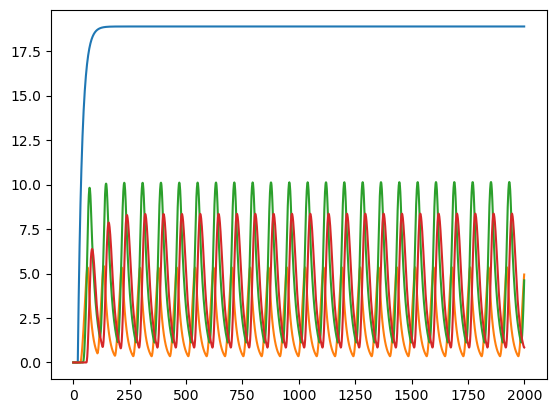

In [25]:
R = results[0][21]


wTable = pd.read_csv("../data/manc t1 connectome data/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)
nonMns = wTable.loc[(wTable["bodyId"]==10093) | (wTable["bodyId"]==10707) | (wTable["bodyId"]==13905) | (wTable["bodyId"]==11751)]
mnIdxs = wTable.loc[wTable["class"]=="motor neuron"].index


for i in nonMns.index:
# for i in mnIdxs:
    plt.plot(R[i])
    #plt.plot(Rtsp[i])

print(np.mean(R))


## Testing osc score

In [31]:
results = sparse.load_npz(cfg.paths.ckpt_dir  / "bdn2.npz").todense().astype(np.float32)

wTable = pd.read_csv("../data/manc t1 connectome data/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)
nonMns = (wTable.loc[(wTable["bodyId"]==10093) | (wTable["bodyId"]==10707) | (wTable["bodyId"]==13905) | (wTable["bodyId"]==11751)]).values
mn_idxs = wTable.loc[wTable["class"]=="motor neuron"].index.values


In [ ]:
from scipy import signal
import numpy as np
def neuron_oscillation_score_helper_old(activity,prominence):
    activity = activity-np.min(activity)
    activity = 2 * activity/np.max(activity) - 1

    autocorr = np.correlate(activity,activity,mode="full") / np.inner(activity,activity)
    lags = signal.correlation_lags(len(activity),len(activity))
    autocorr = autocorr[lags>0]
    lags = lags[lags>0]

    peaks, peakProperties = signal.find_peaks(autocorr,height=(None,None),prominence=prominence)
    if len(peaks) > 0:
        score = np.min([np.max(peakProperties["peak_heights"]),np.max(peakProperties["prominences"])])
        frequency = 1 / peaks[np.argmax(peakProperties["prominences"])]
    else:
        score = 0
        frequency = 0

    return score, frequency

def neuron_oscillation_score_old(activity, returnFrequency=False,prominence=0.05):
    rawScore, frequency = neuron_oscillation_score_helper_old(activity,prominence)
    # normalize to sine wave of the same frequency and duration
    if rawScore == 0:
        score = 0
    else:
        refSinScore, _ = neuron_oscillation_score_helper_old(np.sin(2*np.pi*frequency*np.arange(len(activity))),prominence)
        refCosScore, _ = neuron_oscillation_score_helper_old(np.cos(2*np.pi*frequency*np.arange(len(activity))),prominence)
        refScore = np.max((refSinScore,refCosScore))
        score = rawScore / refScore

    if returnFrequency:
        return score, frequency
    else:
        return score

def sim_oscillation_score_old(R,activeMnIdxs,start=None,end=None,returnFrequency=False):
    """calculate oscillation score for a simulation"""
    if start is None:
        start = 0
    if end is None:
        end = -1

    if returnFrequency:
        neuronOscillationScores = []
        frequencies = []

        for j in activeMnIdxs:
            score, freq = neuron_oscillation_score_old(R[j][start:end],returnFrequency=True)
            neuronOscillationScores.append(score)
            frequencies.append(freq)
        return np.mean(neuronOscillationScores), np.nanmean(frequencies)
        
    else:
        neuronOscillationScores = [neuron_oscillation_score_old(R[j][start:end]) for j in activeMnIdxs] # scores for each neuron
        return np.mean(neuronOscillationScores) # average for the simulation
    
    

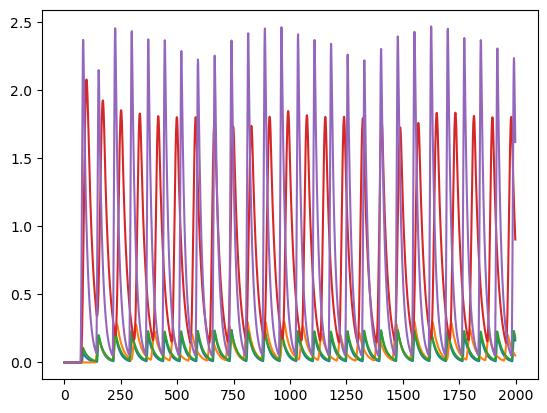

In [26]:
R = results[0][19]
np_R = np.asarray(R)
maxFrs = np.max(np_R,axis=-1)
activeMnIdxs = mnIdxs[maxFrs[mnIdxs]>0]
plt.plot(np_R[activeMnIdxs].T)
plt.show()

In [284]:
R = results[1][1]

score, freq = sim_oscillation_score_old(R,activeMnIdxs,start=250,end=None,returnFrequency=True)
print(f"Score: {score}, Frequency: {freq}")

Frequencies: [np.float64(0.014285714285714285), np.float64(0.014285714285714285)]
Scores: [np.float64(0.9990589790621283), np.float64(0.9981660887241098)]
Score: 0.9986125338931191, Frequency: 0.014285714285714285


In [327]:
maxFrs.shape, R.shape, mnIdxs.shape

((4561,), (4561, 2000), (119,))

array([ 451,  582,  598,  626,  713,  722,  793,  848,  860,  868,  887,
        917,  978,  991, 1020, 1024, 1043, 1044, 1064, 1073, 1104, 1147,
       1169, 1182, 1211, 1270, 1302, 1307, 1354, 1357, 1367, 1396, 1412,
       1436, 1473, 1474, 1482, 1498, 1501, 1557, 1573, 1580, 1685, 1696,
       1723, 1729, 1743, 1773, 1787, 1805, 1828, 1838, 1927, 1973, 2058,
       2065, 2071, 2083, 2086, 2107, 2150, 2153, 2165, 2176, 2256, 2260,
       2279, 2303, 2309, 2379, 2380, 2403, 2408, 2409, 2410, 2419, 2528,
       2581, 2595, 2602, 2605, 2636, 2656, 2667, 2682, 2742, 2790, 2819,
       2821, 2877, 3029, 3088, 3108, 3120, 3138, 3224, 3233, 3283, 3288,
       3462, 3501, 3502, 3506, 3509, 3911, 4156, 4173, 4338, 4339, 4352,
       4358, 4371, 4380, 4400, 4439, 4440, 4465, 4468, 4513])

In [ ]:
(jnp.max(results,axis=-1,keepdims=True)).shape

# mn_activity = jax.lax.dynamic_slice(
#             mn_activity, 
#             (0, start_idx), 
#             (mn_activity.shape[0], mn_activity.shape[1] - start_idx)
#         )

(2, 100, 4561, 1)

In [38]:
mn_idxs.shape

(119,)

20

In [92]:
start = int(cfg.sim.pulseStart/cfg.sim.dt) + 100
R = results[0][0]

max_frs = jnp.max(R, axis=-1)
active_mn_idxs = mn_idxs[max_frs[...,mn_idxs] > 0]
activity = R[active_mn_idxs][..., start:]  # Adjusted to match the original code's start index

score, frequency = jax.vmap(neuron_oscillation_score, in_axes=(0, None))(activity, 0.05)
print(f"Score: {jnp.nanmean(score)}, Frequency: {jnp.nanmean(frequency)}")

Score: 0.7530906200408936, Frequency: 0.00862928107380867


# Testing Pruning

In [3]:
experiment='prune_test'
with initialize(version_base=None, config_path="../configs"):
    cfg=compose(config_name='config.yaml', overrides= [f"experiment={experiment}", "paths=glados", "version=debug", f'run_id=Testing'],return_hydra_config=True,)
    HydraConfig.instance().set_config(cfg)

for k in cfg.paths.keys():
    if (k != 'user'):
        cfg.paths[k] = Path(cfg.paths[k])
        cfg.paths[k].mkdir(parents=True, exist_ok=True)



In [4]:
results = run_vnc_simulation_optimized(cfg)

Loading network configuration...
Running baseline simulation with:
  1 stimulus configurations
  10 parameter sets
  4561 neurons
  2000 time points
Running 10 simulations with batch size 10
Batch 1/1 completed

Simulation completed:
  Total time: 47.47 seconds
  Total simulations: 10
  Time per simulation: 4.7466 seconds
  Throughput: 0.21 sims/second
  Results shape: (1, 10, 4561, 2000)


In [7]:
W_table = load_wTable(cfg.experiment.dfPath)
n_stim_configs = len(cfg.experiment.stimNeurons)

# Prepare parameters
neuron_params = prepare_neuron_params(cfg, W_table)
sim_params = prepare_sim_params(cfg, n_stim_configs, neuron_params.W.shape[0])

# results = sparse.load_npz(cfg.paths.ckpt_dir  / "bdn2.npz").todense().astype(np.float32)

W_table = pd.read_csv("../data/manc t1 connectome data/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)
nonMns = (W_table.loc[(W_table["bodyId"]==10093) | (W_table["bodyId"]==10707) | (W_table["bodyId"]==13905) | (W_table["bodyId"]==11751)]).values
mnIdxs = W_table.loc[W_table["class"]=="motor neuron"].index.values

n_sims = results.shape[0]

In [8]:
sim_params

SimParams(n_neurons=4561, n_param_sets=10, n_stim_configs=1, T=2.0, dt=0.001, pulse_start=0.02, pulse_end=1.999, t_axis=Array([0.0000000e+00, 1.0000000e-03, 2.0000001e-03, ..., 1.9970001e+00,
       1.9980001e+00, 1.9990001e+00], dtype=float32), exc_multiplier=0.03, inh_multiplier=0.03, noise_stdv_prop=0.1, r_tol=1e-07, a_tol=1e-09)

In [ ]:
def _create_work_queue(params, n_stim_configs, n_param_sets) -> list:
    """Create a work queue with stimulus tracking metadata."""
    work_queue = []

    # Prepare standard deviation propagation parameters
    if config.noise:
        additional_param = config.noise_stdv_prop
    else:
        additional_param = 0.0
    ntotal = 0
    # Create work items: (stim_idx, param_idx, parameters)
    for stim_idx in range(n_stim_configs):
        for param_idx in range(n_param_sets):
            work_item = {
                "total_count": ntotal,
                "param_idx": param_idx,
                "stim_idx": stim_idx,
                "tau": params.tau[param_idx],
                "threshold": params.threshold[param_idx],
                "a": params.a[param_idx],
                "fr_cap": params.fr_cap[param_idx],
                "seed": params.seeds[param_idx],
                "stdvProp": additional_param,
                "inputs": params.input_currents_list[stim_idx],
            }
            work_queue.append(work_item)
            ntotal += 1

    return work_queue

In [123]:
all_neurons = np.arange(config.n_neurons)
mn_idxs = jnp.asarray(wTable.loc[wTable["class"]=="motor neuron"].index.values)
in_idxs = jnp.setdiff1d(all_neurons, mn_idxs)
removed_stim_neurons = [jnp.array([], dtype=jnp.int32) for _ in range(n_sims)]
prev_neurons_put_back = [jnp.array([], dtype=jnp.int32) for _ in range(n_sims)]

In [ ]:
import jax
import jax.numpy as jnp
from jax import random
from functools import partial
import pandas as pd
import numpy as np
from src.sim_utils import neuron_oscillation_score


@jax.jit
def removal_probability(max_frs, neurons_to_exclude_mask):
    """Assign a probability of removal to each neuron based on their max FR"""
    tmp = 1.0 / jnp.where(max_frs > 0, max_frs, 1.0)  # Avoid division by zero
    tmp = jnp.where(jnp.isfinite(tmp), tmp, 0.0)
    tmp = jnp.where(neurons_to_exclude_mask, 0.0, tmp)
    
    # Normalize probabilities
    p_sum = jnp.sum(tmp)
    p = jnp.where(p_sum > 0, tmp / p_sum, 0.0)
    
    return p

@jax.jit
def jax_choice(key, a, p):
    """JAX-compatible choice function"""
    # Handle edge case where all probabilities are zero
    p_sum = jnp.sum(p)
    p_normalized = jnp.where(p_sum > 0, p, jnp.ones_like(p) / len(p))
    
    # Use categorical sampling
    return random.categorical(key, jnp.log(p_normalized + 1e-10))

@partial(jax.jit, static_argnames=['start_idx'])
def get_active_mn_activity(R, mn_idxs, start_idx):
    """Get activity for active motor neurons in a JAX-compatible way"""
    max_frs = jnp.max(R, axis=1)
    mn_max_frs = max_frs[mn_idxs]
    active_mask = mn_max_frs > 0
    
    # Use static slicing with lax.dynamic_slice for the time dimension
    mn_activity = R[mn_idxs]
    if start_idx > 0:
        # Use dynamic_slice instead of dynamic indexing
        mn_activity = jax.lax.dynamic_slice(
            mn_activity, 
            (0, start_idx), 
            (mn_activity.shape[0], mn_activity.shape[1] - start_idx)
        )
    
    # Zero out activity for inactive neurons
    masked_activity = jnp.where(
        active_mask[:, None], 
        mn_activity, 
        jnp.zeros_like(mn_activity)
    )
    
    return masked_activity, active_mask


def safe_setdiff1d(ar1, ar2, max_size):
    """JAX-compatible setdiff1d with fixed output size"""
    # Create a mask for elements in ar1 that are not in ar2
    mask = ~jnp.isin(ar1, ar2)
    # Get the indices where mask is True
    result_indices = jnp.where(mask, ar1, -1)
    # Filter out -1 values and pad to max_size
    valid_mask = result_indices >= 0
    valid_values = jnp.where(valid_mask, result_indices, 0)
    
    # Count valid elements
    n_valid = jnp.sum(valid_mask)
    
    # Create output array with fixed size
    output = jnp.full(max_size, -1, dtype=jnp.int32)
    output = output.at[:len(ar1)].set(valid_values)
    
    # Mask invalid elements
    final_mask = jnp.arange(max_size) < n_valid
    return jnp.where(final_mask, output, -1), n_valid


def safe_concatenate(arr1, arr2, max_total_size):
    """JAX-compatible concatenate with fixed output size"""
    # Count valid elements in each array (assuming -1 means invalid)
    valid1 = jnp.sum(arr1 >= 0)
    valid2 = jnp.sum(arr2 >= 0)
    
    # Create output array
    output = jnp.full(max_total_size, -1, dtype=jnp.int32)
    
    # Copy valid elements from arr1
    output = output.at[:valid1].set(arr1[arr1 >= 0][:valid1])
    
    # Copy valid elements from arr2
    valid_arr2 = arr2[arr2 >= 0]
    output = output.at[valid1:valid1+valid2].set(valid_arr2[:valid2])
    
    return output, valid1 + valid2


@partial(jax.jit, static_argnames=['max_neurons', 'oscillation_threshold'])
def update_single_sim_state(state, R, mn_idxs, in_idxs, oscillation_threshold, max_neurons=1000):
    """Update state for a single simulation - now handles convergence check inside JIT"""
    (remove_neurons, neurons_put_back, last_removed, 
        p, level, removed_stim_neurons, key) = state
    
    start = 250
    
    # Get active MN activity using JAX-compatible approach
    mn_activity, active_mask = get_active_mn_activity(R, mn_idxs, start)
    
    # Compute oscillation score
    oscillation_score = jax.vmap(neuron_oscillation_score, in_axes=(0, None))(mn_activity, 0.05)
    oscillation_score = jnp.nanmean(jnp.where(active_mask, oscillation_score, jnp.nan))

    # Check if oscillation is below threshold
    reset_condition = (oscillation_score < oscillation_threshold) | jnp.isnan(oscillation_score)
    
    def reset_branch():
        # Put back the last removed neuron using safe operations
        new_remove_neurons, n_remaining = safe_setdiff1d(
            remove_neurons, jnp.array([last_removed]), max_neurons
        )
        
        # Add last_removed to neurons_put_back
        new_neurons_put_back, n_put_back = safe_concatenate(
            neurons_put_back, jnp.array([last_removed]), max_neurons
        )
        
        # Update probabilities to exclude put-back neurons
        exclude_mask = jnp.isin(in_idxs, new_neurons_put_back[:n_put_back])
        exclude_mask = exclude_mask | jnp.isin(in_idxs, removed_stim_neurons)
        new_p = removal_probability(jnp.ones(len(in_idxs)), exclude_mask)
        
        # Check if we can continue
        p_sum = jnp.sum(new_p)
        converged = p_sum <= 1e-10
        
        key, subkey = random.split(key)
        neuron_idx = jax_choice(subkey, jnp.arange(len(in_idxs)), new_p)
        new_neuron_to_remove = in_idxs[neuron_idx]
        
        # Add new neuron to remove list
        final_remove_neurons, _ = safe_concatenate(
            new_remove_neurons[:n_remaining], 
            jnp.array([new_neuron_to_remove]), 
            max_neurons
        )
        
        return (final_remove_neurons, new_neurons_put_back, new_neuron_to_remove, 
                new_p, level, removed_stim_neurons, key, converged)
    
    def continue_branch():
        # Get max firing rates for all neurons
        max_frs = jnp.max(R, axis=1)
        
        # Find silent interneurons
        silent_mask = (max_frs == 0)
        silent_in_mask = silent_mask[in_idxs]
        
        # Get silent interneuron indices
        silent_ins = jnp.where(silent_in_mask, in_idxs, -1)
        n_silent = jnp.sum(silent_in_mask)
        
        # Add silent neurons to removal list
        new_remove_neurons, _ = safe_concatenate(
            remove_neurons, silent_ins, max_neurons
        )
        
        # Update probabilities based on firing rates
        exclude_mask = jnp.isin(in_idxs, neurons_put_back)
        exclude_mask = exclude_mask | jnp.isin(in_idxs, removed_stim_neurons)
        new_p = removal_probability(max_frs[in_idxs], exclude_mask)
        
        # Check if we can continue
        p_sum = jnp.sum(new_p)
        converged = p_sum <= 1e-10
        
        key, subkey = random.split(key)
        neuron_idx = jax_choice(subkey, jnp.arange(len(in_idxs)), new_p)
        new_neuron_to_remove = in_idxs[neuron_idx]
        
        # Add new neuron to remove list
        final_remove_neurons, _ = safe_concatenate(
            new_remove_neurons, 
            jnp.array([new_neuron_to_remove]), 
            max_neurons
        )
        
        return (final_remove_neurons, neurons_put_back, new_neuron_to_remove, 
                new_p, level, removed_stim_neurons, key, converged)
    
    return jax.lax.cond(reset_condition, reset_branch, continue_branch)

def run_pruning_from_start_jax(params, oscillation_threshold=0.1):
    """JAX-compatible version of run_pruning_from_start"""
    # Load data (this part stays on CPU)
    w_table = pd.read_csv(params["dfPath"], index_col=0)
    all_neurons = w_table.index.to_numpy()
    mn_idxs = jnp.array(w_table.loc[w_table["class"] == "motor neuron"].index)
    in_idxs = jnp.array(np.setdiff1d(all_neurons, mn_idxs))
    
    # Initialize state with fixed-size arrays
    n_sims = params["nSims"]
    max_neurons = 1000  # Set appropriate maximum
    
    # Initialize with fixed-size arrays filled with -1 (invalid marker)
    removed_stim_neurons = [jnp.full(max_neurons, -1, dtype=jnp.int32) for _ in range(n_sims)]
    prev_neurons_put_back = [jnp.full(max_neurons, -1, dtype=jnp.int32) for _ in range(n_sims)]
    
    min_rs, minimal_circuit_params = run_pruning_from_params_jax(
        params, 0, prev_neurons_put_back, mn_idxs, in_idxs, 
        oscillation_threshold, removed_stim_neurons, max_neurons
    )
    
    return min_rs, minimal_circuit_params

def run_pruning_from_params_jax(params, iter_start, prev_neurons_put_back, 
                                mn_idxs, in_idxs, oscillation_threshold, 
                                removed_stim_neurons, max_neurons=1000):
    """JAX-compatible version of run_pruning_from_params"""
    
    screen_str = params["name"]
    n_sims = params["nSims"]
    
    # Initialize state arrays with fixed sizes
    level = jnp.zeros(n_sims, dtype=jnp.int32)
    last_removed = jnp.full(n_sims, -1, dtype=jnp.int32)
    neurons_put_back = [jnp.full(max_neurons, -1, dtype=jnp.int32) for _ in range(n_sims)]
    min_circuit = jnp.full(n_sims, False)
    
    # Initialize probabilities
    p_arrays = []
    for i in range(n_sims):
        # Convert removeNeurons to fixed-size array
        remove_neurons_arr = jnp.full(max_neurons, -1, dtype=jnp.int32)
        if len(params["removeNeurons"][i]) > 0:
            remove_neurons_arr = remove_neurons_arr.at[:len(params["removeNeurons"][i])].set(
                jnp.array(params["removeNeurons"][i])
            )
        
        # Create exclusion mask
        exclude_neurons, _ = safe_concatenate(
            remove_neurons_arr, removed_stim_neurons[i], max_neurons * 2
        )
        exclude_mask = jnp.isin(in_idxs, exclude_neurons[exclude_neurons >= 0])
        p_i = removal_probability(jnp.ones(len(in_idxs)), exclude_mask)
        p_arrays.append(p_i)
    
    # Create master random key
    master_key = random.PRNGKey(params.get("master_seed", 42))
    
    # Main pruning loop
    iteration = iter_start
    max_iterations = 1000  # Safety limit
    
    while not jnp.all(min_circuit) and iteration < max_iterations:
        print(f"Iteration {iteration}")
        
        # Resample seeds for non-converged simulations
        resample_idxs = jnp.where(~min_circuit)[0]
        master_key, *subkeys = random.split(master_key, len(resample_idxs) + 1)
        
        # for idx, sim in enumerate(resample_idxs):
        #     params["seed"][sim] = int(random.randint(subkeys[idx], (), 0, 100000))
        
        # Run simulations (you need to implement this part)
        R = single_run(params) 
        # For now, we'll assume Rs is available
        
        # Update each simulation state
        for i in range(n_sims):
            if min_circuit[i]:
                continue
            
            # Convert removeNeurons to fixed-size array
            remove_neurons_arr = jnp.full(max_neurons, -1, dtype=jnp.int32)
            if len(params["removeNeurons"][i]) > 0:
                remove_neurons_arr = remove_neurons_arr.at[:len(params["removeNeurons"][i])].set(
                    jnp.array(params["removeNeurons"][i])
                )
            
            state = (
                remove_neurons_arr,
                neurons_put_back[i],
                last_removed[i],
                p_arrays[i],
                level[i],
                removed_stim_neurons[i],
                subkeys[i] if i < len(subkeys) else master_key
            )
            
            # Note: You need to pass R here - it should come from your simulation
            new_state = update_single_sim_state(
                state, R, mn_idxs, in_idxs, oscillation_threshold, max_neurons
            )
            
            # Unpack new state (commented out until R is available)
            (new_remove_neurons, new_neurons_put_back, new_last_removed, 
             new_p, new_level, new_removed_stim_neurons, _, converged) = new_state
            
            # Update params and state (commented out until R is available)
            valid_neurons = new_remove_neurons[new_remove_neurons >= 0]
            params["removeNeurons"][i] = valid_neurons.tolist()
            neurons_put_back[i] = new_neurons_put_back
            last_removed = last_removed.at[i].set(new_last_removed)
            min_circuit = min_circuit.at[i].set(converged)
            p_arrays[i] = new_p
            level = level.at[i].set(new_level)
            removed_stim_neurons[i] = new_removed_stim_neurons
        
        iteration += 1
    
    # Return placeholder values (you need to implement the actual return)
    return None, params

In [125]:
remove_neurons = [jnp.array([], dtype=jnp.int32) for _ in range(n_sims)]

In [ ]:
# Initialize state arrays
level = jnp.zeros(n_sims, dtype=jnp.int32)
last_removed = jnp.full(n_sims, -1, dtype=jnp.int32)  # Use -1 for None
neurons_put_back = [jnp.array([], dtype=jnp.int32) for _ in range(n_sims)]
min_circuit = jnp.full(n_sims, False)
oscillation_threshold=0.1

# Initialize probabilities
p_arrays = []
for i in range(n_sims):
    exclude_mask = jnp.isin(in_idxs, jnp.concatenate([
        jnp.array(remove_neurons[i]), 
        removed_stim_neurons[i]
    ]))
    p_i = removal_probability(jnp.ones(len(in_idxs)), exclude_mask)
    p_arrays.append(p_i)


In [161]:
max_frs[mn_idxs].shape, (max_frs[mn_idxs] > 0).shape

((119,), (119,))

In [164]:

max_frs = jnp.max(R, axis=-1)
active_mn_mask = max_frs[mn_idxs] > 0
active_mn_idxs = jnp.where(active_mn_mask, mn_idxs, -1)
active_mn_idxs = jnp.extract(active_mn_idxs >= 0, active_mn_idxs)

start = 250
end = R.shape[1]  # Use full time range
# active_mn_idxs = mn_idxs[max_frs[mn_idxs] > 0]


Array([860, 868], dtype=int32)

In [138]:

# Create master random key
master_key = random.PRNGKey(cfg.experiment.seed)
iter_start=0
# Main pruning loop
iteration = iter_start
max_iterations = 1000  # Safety limit

# while not jnp.all(min_circuit) and iteration < max_iterations:
print(f"Iteration {iteration}")

# Resample seeds for non-converged simulations
resample_idxs = jnp.where(~min_circuit)[0]
master_key, *subkeys = random.split(master_key, len(resample_idxs) + 1)

# add in sim here

Rs = results[1][0]
# Update each simulation state
# for i in range(n_sims):
i = 0


state = (
    jnp.array(remove_neurons[i]),
    neurons_put_back[i],
    last_removed[i],
    p_arrays[i],
    level[i],
    removed_stim_neurons[i],
    subkeys[i] if i < len(subkeys) else master_key
)


Iteration 0


In [168]:

# This function is JIT compiled but doesn't need to handle min_circuit
new_state = update_single_sim_state(state, Rs, mn_idxs, in_idxs, oscillation_threshold
)


IndexError: Array slice indices must have static start/stop/step to be used with NumPy indexing syntax. Found slice(Traced<~int32[]>with<DynamicJaxprTrace>, None, None). To index a statically sized array at a dynamic position, try lax.dynamic_slice/dynamic_update_slice (JAX does not support dynamically sized arrays within JIT compiled functions).

In [137]:
new_state = update_single_sim_state(state, R, mn_idxs, in_idxs, oscillation_threshold)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function update_single_sim_state at /tmp/ipykernel_2263973/909641254.py:25 for jit. This concrete value was not available in Python because it depends on the value of the argument state[3].
See https://docs.jax.dev/en/latest/errors.html#jax.errors.TracerBoolConversionError

UnboundLocalError: cannot access local variable 'key' where it is not associated with a value

# Stim Adjustment Testing

In [ ]:


def run_with_stim_adjustment(self,maxIters=10,clampedNeurons=[],clampedRates=None,nActiveUpper=500,nActiveLower=5,nHighFrUpper=100):
    nextHighest = None
    nextLowest = None

    for i in range(maxIters):
        self.run(clampedNeurons=clampedNeurons,clampedRates=clampedRates)
        R = self.R

        nActive = sum(np.sum(R,1)>0)
        nHighFr = sum(np.max(R,1)>100)

        currInputs = self.inputs.copy()

        print(f"Run {i}")
        print(f"max stimI = {np.max(currInputs)}")
        print(f"nActive: {nActive}")
        print(f"nHighFr: {nHighFr}")

        if (nActive > nActiveUpper) or (nHighFr > nHighFrUpper): # too strong
            if nextLowest is None:
                newInputs = currInputs/2
            else:
                newInputs = (currInputs+nextLowest)/2
            nextHighest = currInputs
        elif (nActive < nActiveLower): # too weak
            if nextHighest is None:
                newInputs = currInputs*2
            else:
                newInputs = (currInputs+nextHighest)/2
            nextLowest = currInputs
        else:
            break

        self.set_input(newInputs)

In [ ]:

# Note: The run_with_stim_adjustment function cannot be easily JIT-compiled
# because it involves loops with data-dependent control flow and side effects.
# Here's a restructured version that separates the JIT-able parts:

@jit
def compute_activity_metrics(R):
    """JIT-compatible function to compute activity metrics."""
    n_active = jnp.sum(jnp.sum(R, axis=1) > 0)
    n_high_fr = jnp.sum(jnp.max(R, axis=1) > 100)
    return n_active, n_high_fr

@jit
def update_inputs_binary_search(curr_inputs, next_lowest, next_highest, 
                               n_active, n_high_fr, n_active_upper, 
                               n_active_lower, n_high_fr_upper):
    """JIT-compatible input update logic."""
    
    # Determine if stimulation is too strong
    too_strong = (n_active > n_active_upper) | (n_high_fr > n_high_fr_upper)
    too_weak = n_active < n_active_lower
    
    # Update inputs based on binary search logic
    def update_for_too_strong():
        new_inputs = jnp.where(
            next_lowest is None,
            curr_inputs / 2,
            (curr_inputs + next_lowest) / 2
        )
        new_next_highest = curr_inputs
        return new_inputs, next_lowest, new_next_highest
    
    def update_for_too_weak():
        new_inputs = jnp.where(
            next_highest is None,
            curr_inputs * 2,
            (curr_inputs + next_highest) / 2
        )
        new_next_lowest = curr_inputs
        return new_inputs, new_next_lowest, next_highest
    
    def no_update():
        return curr_inputs, next_lowest, next_highest
    
    # Apply updates conditionally
    new_inputs, new_next_lowest, new_next_highest = jax.lax.cond(
        too_strong,
        update_for_too_strong,
        lambda: jax.lax.cond(
            too_weak,
            update_for_too_weak,
            no_update
        )
    )
    
    converged = ~too_strong & ~too_weak
    
    return new_inputs, new_next_lowest, new_next_highest, converged

# Example usage:
def run_with_stim_adjustment_jax(simulation_runner, max_iters=10, 
                                clamped_neurons=None, clamped_rates=None,
                                n_active_upper=500, n_active_lower=5, 
                                n_high_fr_upper=100):
    """
    JAX-compatible version of run_with_stim_adjustment.
    Note: This requires the simulation_runner to be compatible with JAX.
    """
    next_highest = None
    next_lowest = None
    
    for i in range(max_iters):
        # Run simulation (this part depends on your simulation framework)
        R = simulation_runner.run(clamped_neurons=clamped_neurons, 
                                 clamped_rates=clamped_rates)
        
        # Compute metrics (JIT-compiled)
        n_active, n_high_fr = compute_activity_metrics(R)
        curr_inputs = simulation_runner.get_inputs()
        
        print(f"Run {i}")
        print(f"max stimI = {jnp.max(curr_inputs)}")
        print(f"nActive: {n_active}")
        print(f"nHighFr: {n_high_fr}")
        
        # Update inputs (JIT-compiled)
        new_inputs, next_lowest, next_highest, converged = update_inputs_binary_search(
            curr_inputs, next_lowest, next_highest, n_active, n_high_fr,
            n_active_upper, n_active_lower, n_high_fr_upper
        )
        
        if converged:
            break
            
        simulation_runner.set_input(new_inputs)

# Additional utility functions for JAX compatibility:

@jit
def safe_divide(x, y, default=0.0):
    """Safe division that handles division by zero."""
    return jnp.where(y == 0, default, x / y)

@jit
def safe_max(x, default=0.0):
    """Safe max that handles empty arrays."""
    return jnp.where(len(x) == 0, default, jnp.max(x))

@jit
def safe_min(x, default=0.0):
    """Safe min that handles empty arrays."""
    return jnp.where(len(x) == 0, default, jnp.min(x))